(6750281, 6)
         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466
            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09

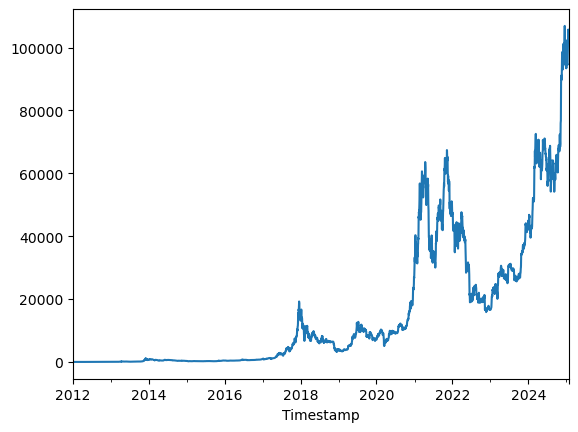

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

#miro donde hay nulls si los hay
train.isna().sum()

filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

train = train.dropna()
print(train)

train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('d').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

In [2]:
# 1 año a considerar en el conjunto de test
n_steps = 365

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

In [3]:
# Aplicar auto_arima para encontrar los mejores parámetros
m=365
modelo_auto = auto_arima(train, start_p=1, start_q=1, max_p=20, max_q=20, max_order=60,
                         seasonal=False, stepwise=True, trace=True, error_action='ignore',
                         m=7, suppress_warnings=True)


# Mostrar resumen del modelo seleccionado
print(modelo_auto.summary())

C:\Users\g3rm4\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=68389.209, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68552.692, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=68389.905, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=68388.930, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=68551.920, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=68388.604, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=68381.278, Time=1.81 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=68379.369, Time=2.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=68390.191, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=68346.721, Time=3.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=68382.901, Time=1.48 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=68375.553, Time=2.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=68378.999, Time=3.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=68379.318, Time=4.19 sec
 ARIMA(4,1,1)(0,0,0

In [4]:
forecast = modelo_auto.predict(n_steps)
forecast_index = test.index

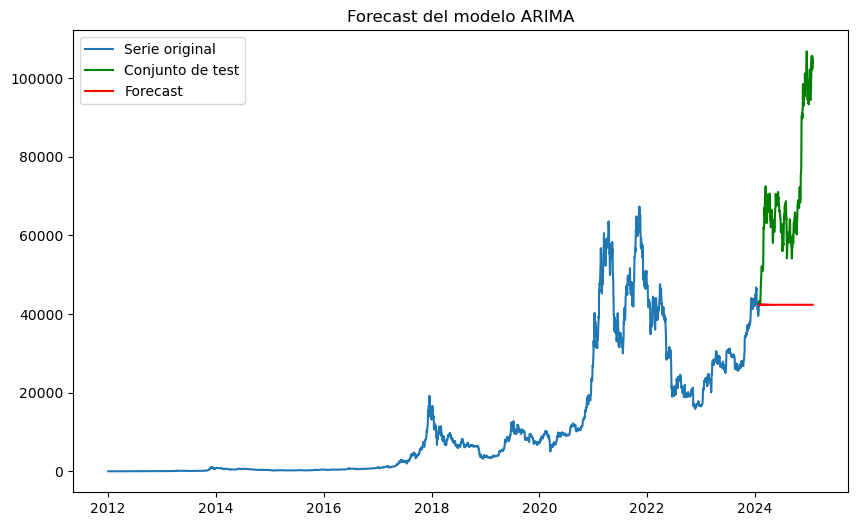

MAE: 27782.45
MAPE: 36.86%


In [5]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.savefig("Forecast_ARIMA_daily.png")
plt.show()

# Evaluación del modelo
mae  = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

In [6]:
del modelo_auto      # elimina la referencia al objeto

In [7]:
modelo_auto_sarimax = auto_arima(train, start_p=1, start_q=1, max_p=20, max_q=20, max_order=60,
                         seasonal=True, stepwise=True, trace=True, error_action='ignore',
                         m=7, suppress_warnings=True)


# Mostrar resumen del modelo seleccionado
print(modelo_auto_sarimax.summary())

# Forecast
forecast = modelo_auto_sarimax.predict(n_steps)
forecast_index = test.index

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=68387.871, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=68552.692, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=68386.572, Time=0.45 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=68386.124, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=68551.920, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=68388.930, Time=0.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=68387.818, Time=1.51 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=68387.484, Time=0.81 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=68386.265, Time=0.37 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=68389.407, Time=1.12 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=68550.201, Time=0.29 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=68386.138, Time=0.89 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=68385.501, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=68388.604, Time=0.32 sec
 ARIMA(0,1,2)(1,0,1

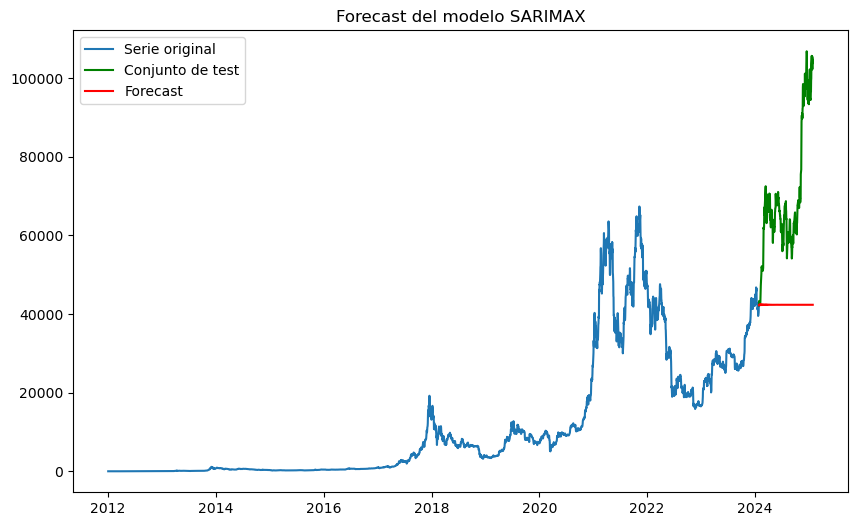

MAE: 27782.45
MAPE: 36.86%


In [8]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.savefig("Forecast_SARIMAX_daily.png")
plt.show()


# Evaluación del modelo
mae  = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast) * 100
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")